In [1]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ipywidgets import widgets
import math
import numpy as np

# Load initial points
initial_points = [
    (500, 3000),
    (1000, 4000),
    (300, 3000),
    (6000, 1000),
]

points = []
point_coords = [initial_points]
selected_line_index = 0

def plot_initial_points():
    for x, y in initial_points:
        point, = ax.plot(x, y, marker='o', markersize=10)
        points.append(point)
        #point_coords.append((x, y))
    inclination_slider = create_inclination_slider(len(inclination_sliders) + 1)
    inclination_sliders.append(inclination_slider)
    
    declination_slider = create_declination_slider(len(declination_sliders) + 1)
    declination_sliders.append(declination_slider)
    
    intensity_slider = create_intensity_slider(len(intensity_sliders) + 1)
    intensity_sliders.append(intensity_slider)    
    display(intensity_slider)    
    display(inclination_slider)
    display(declination_slider)

def find_closest_point(x, y, threshold=1.0):
    min_distance = float('inf')
    closest_point = None
    closest_index = None
    
    for i, (px, py) in enumerate(point_coords[-1]):
        distance = ((px - x) ** 2 + (py - y) ** 2) ** 0.5
        if distance < min_distance and distance < threshold:
            min_distance = distance
            closest_point = points[i]
            closest_index = i
            
    return closest_point, closest_index

def on_click(event):
    global points, point_coords
    x, y = event.xdata, event.ydata
    threshold = 200.0

    closest_point, closest_index = find_closest_point(x, y, threshold)

    if closest_point is not None:
        closest_point.set_data(x, y)
        point_coords[-1][closest_index] = (x, y)
    else:
        point, = ax.plot(x, y, marker='o', markersize=10)
        points.append(point)
        point_coords[-1].append((x, y))

    update_line()

def clockwise_sort(points):
    if len(points) < 2:
        return points

    centroid_x = sum(p[0] for p in points) / len(points)
    centroid_y = sum(p[1] for p in points) / len(points)

    def angle(point):
        dx, dy = point[0] - centroid_x, point[1] - centroid_y
        return math.atan2(dy, dx)

    sorted_points = sorted(points, key=angle, reverse=True)
    return sorted_points

def update_line():
    global points, point_coords

    # Clear the plot
    ax.clear()
    ax.set_xlim(0, 20000)
    ax.set_ylim(10000, 0)
    ax.set_xlabel('East (m)')
    ax.set_ylabel('Depth (m)')
    # Plot all the lines
    for line_coords in point_coords:
        if len(line_coords) < 2:
            continue
        sorted_points = clockwise_sort(line_coords)
        sorted_points.append(sorted_points[0])
        ax.plot(*zip(*sorted_points),marker='o', linestyle='-', linewidth=2, zorder=-1)

    # Update the current line
    if len(point_coords[-1]) < 2:
        line.set_data([], [])
        fig.canvas.draw()
        return

    sorted_points = clockwise_sort(point_coords[-1])
    sorted_points.append(sorted_points[0])

    point_coords[-1] = sorted_points[:-1]
    points = [points[point_coords[-1].index(coord)] for coord in sorted_points[:-1]]

    line.set_data(list(zip(*sorted_points)))
    ax.plot(*zip(*sorted_points), linestyle='-', linewidth=2, zorder=-1)
    fig.canvas.draw()

def clear_points(_):
    global points, point_coords
    global inclination_sliders
    global declination_sliders
    global intensity_sliders

    for point in points:
        point.remove()
    points.clear()
    point_coords.clear()
    point_coords.append([])
    update_line()
    if len(inclination_sliders)>1:
        for slider in inclination_sliders[1:len(inclination_sliders)]:
            slider.close()
        for slider in declination_sliders[1:len(declination_sliders)]:
            slider.close()
        for slider in intensity_sliders[1:len(intensity_sliders)]:
            slider.close()
        inclination_sliders=[inclination_sliders[0]]
        declination_sliders=[declination_sliders[0]]
        intensity_sliders=[intensity_sliders[0]]


def clear_current_body(_):
    global points, point_coords
    global inclination_sliders
    global declination_sliders
    global intensity_sliders
    for point in points:
        point.remove()
    points.clear()
    point_coords[-1]=[]
    if len(inclination_sliders)>1:
        inclination_sliders[-1].close()
        declination_sliders[-1].close()
        intensity_sliders[-1].close()

        inclination_sliders=inclination_sliders[0:-1]
        declination_sliders=declination_sliders[0:-1]
        intensity_sliders=intensity_sliders[0:-1]
    update_line()    


def cal_mag(source,z_height,inten,inclin,declin):
    

    import sys
    # in this case local import
    sys.path.append("../")
    import mag2dpoly as mag


    # angle with the North axis
    northxax = 90.0

    # number of observation
    Nobs = 101
    xzobs = np.transpose(np.vstack(( np.linspace(0.0,20000.0,Nobs), -z_height*np.ones(Nobs))))

    
    
    input_all=source
    nbod = len(input_all)
    bodyindices = np.empty(shape=(nbod,), dtype=np.object)
    vertices=[]
    Jd=[]
    Jm=[]
    indss=0
    for i in range(len(input_all)):
        inds = range(indss,len(np.array(input_all)[i])+indss)
        bodyindices[i] = np.array(inds)
        vertices= vertices+input_all[i]
        Jind = mag.MagnetizVector(mod=inten[i],Ideg=inclin[i],Ddeg=declin[i])
        Jrem = mag.MagnetizVector(mod=0,Ideg=90,Ddeg=0.0)
        Jd= Jd+[Jind]
        Jm= Jm+[Jrem]
        indss=len(np.array(input_all)[i])+indss

    # construct the poligonal body object
    pbody = mag.MagPolyBodies2D(bodyindices,np.array(vertices))


    # type of forward algorithm
    forwardtype = "talwani"

    # compute total field
    # make Jind and Jrem arrays of objects (as many as there are bodies)
    Jindv = np.array(Jd) # we have one single body in this case
    Jremv = np.array(Jm) # we have one single body in this case
    tmag = mag.tmagpolybodies2Dgen(xzobs,Jindv,Jremv,northxax,pbody,forwardtype)
    
    return tmag


def update_mag(_):
    global point_coords
    global height
    global inclination_sliders
    global declination_sliders
    global intensity_sliders
    source_body=point_coords[:]

    if len(point_coords)>len(inclination_sliders):
        source_body.remove([])
    Nobs = 101
    xzobs = np.transpose(np.vstack(( np.linspace(0.0,20000.0,Nobs), -1.0*np.ones(Nobs))))
    inclin_values = [slider.value for slider in inclination_sliders]
    declin_values = [slider.value for slider in declination_sliders]
    intensity_values = [slider.value for slider in intensity_sliders]
    
    tmag = cal_mag(source_body,height.value,intensity_values,inclin_values,declin_values)
    ax1.plot(xzobs[:,0],tmag,"o-")
    fig.canvas.draw()

def clear_mag(_):
    ax1.clear()
    ax1.set_xlim(0, 20000)
    ax1.plot([],[],"o-")
    ax1.set_xlabel('East (m)')
    ax1.set_ylabel('Total Magnetic Intensity (nT)')

# Create buttons
clear_button = widgets.Button(description='Clear All Mag Body')
clear_button.on_click(clear_points)

clear_current_button = widgets.Button(description='Clear Current Mag Body')
clear_current_button.on_click(clear_current_body)


update_mag_button = widgets.Button(description='Calculate Mag')
update_mag_button.on_click(update_mag)

clear_mag_button = widgets.Button(description='Clear Mag')
clear_mag_button.on_click(clear_mag)

height=widgets.IntSlider(
    min=0,
    max=10000,
    step=1000,
    description='Flight_height_above_ground:',
    value=1000
)
inclination_sliders = []
declination_sliders = []
intensity_sliders = []


def create_intensity_slider(body_index):
    slider = widgets.IntSlider(
        min=0,
        max=10,
        step=1,
        description=f'Mangetization {body_index}:',
        value=4
    )
    return slider

def create_inclination_slider(body_index):
    slider = widgets.IntSlider(
        min=-90,
        max=90,
        step=5,
        description=f'Inclination {body_index}:',
        value=90
    )
    return slider

def create_declination_slider(body_index):
    slider = widgets.IntSlider(
        min=-90,
        max=90,
        step=5,
        description=f'Declination {body_index}:',
        value=0
    )
    return slider

def add_body_with_sliders(_):
    global point_coords
    global inclination_sliders
    global declination_sliders
    global intensity_sliders
    
    point_coords.append([])
    update_line()
    
    inclination_slider = create_inclination_slider(len(inclination_sliders) + 1)
    inclination_sliders.append(inclination_slider)
    
    declination_slider = create_declination_slider(len(declination_sliders) + 1)
    declination_sliders.append(declination_slider)

    intensity_slider = create_intensity_slider(len(intensity_sliders) + 1)
    intensity_sliders.append(intensity_slider)
    
    display(intensity_slider)    
    display(inclination_slider)
    display(declination_slider)

add_body_with_sliders_button = widgets.Button(description='Add Mag Body')
add_body_with_sliders_button.on_click(add_body_with_sliders)



<IPython.core.display.Javascript object>


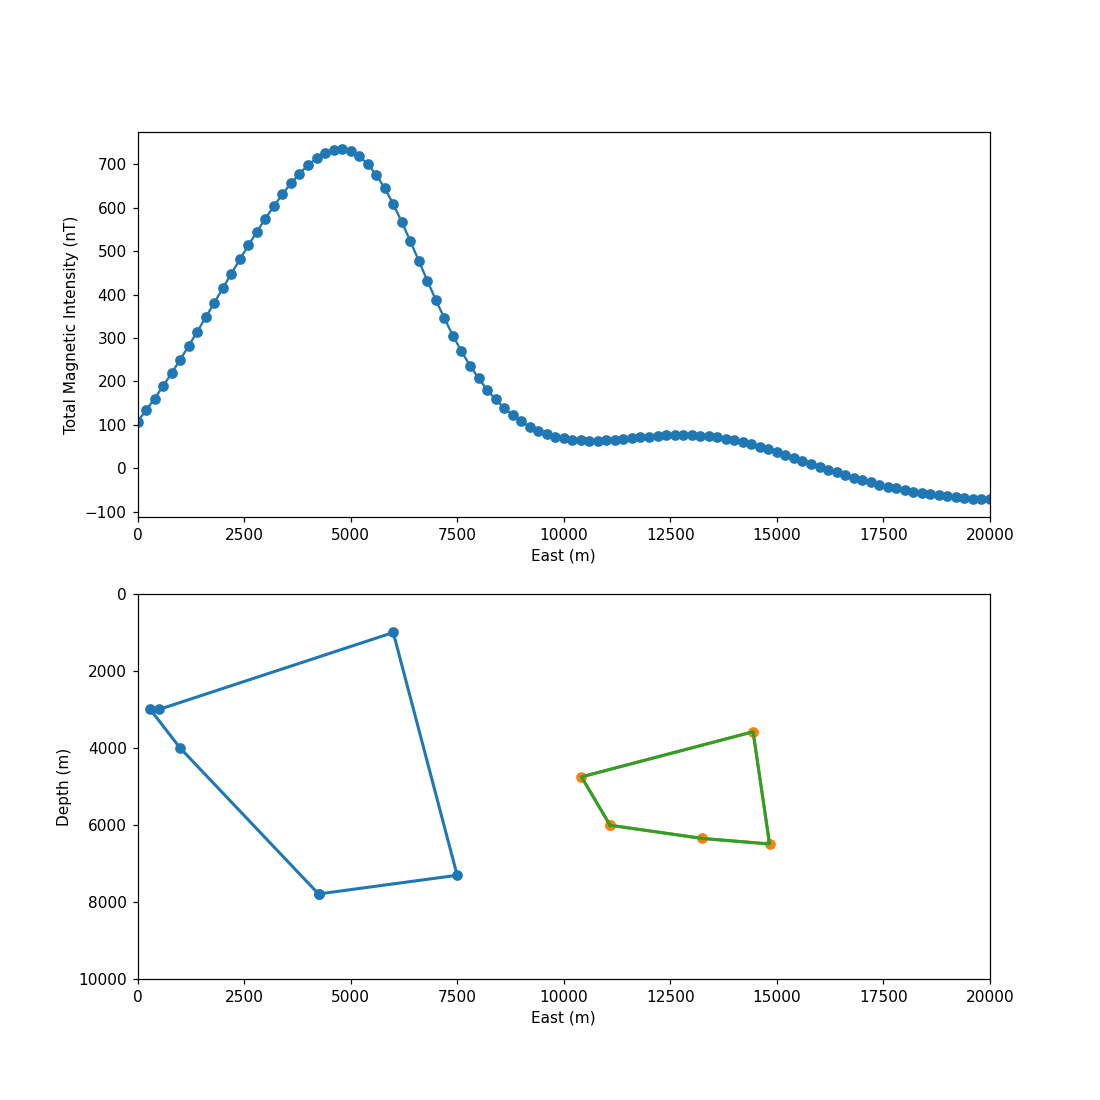

IntSlider(value=1000, description='Flight_height_above_ground:', max=10000, step=1000)

Button(description='Add Mag Body', style=ButtonStyle())

Button(description='Clear All Mag Body', style=ButtonStyle())

Button(description='Clear Current Mag Body', style=ButtonStyle())

Button(description='Calculate Mag', style=ButtonStyle())

Button(description='Clear Mag', style=ButtonStyle())

IntSlider(value=4, description='Mangetization 1:', max=10)

IntSlider(value=90, description='Inclination 1:', max=90, min=-90, step=5)

IntSlider(value=0, description='Declination 1:', max=90, min=-90, step=5)

IntSlider(value=4, description='Mangetization 2:', max=10)

IntSlider(value=90, description='Inclination 2:', max=90, min=-90, step=5)

IntSlider(value=0, description='Declination 2:', max=90, min=-90, step=5)

In [2]:


# Set up the plot
fig, (ax1, ax) = plt.subplots(2, 1, figsize=(10, 10))
fig.canvas.mpl_connect('button_press_event', on_click)
line, = ax.plot([], [], linestyle='-', linewidth=2, zorder=-1)

ax.set_xlim(0, 20000)
ax.set_ylim(10000, 0)
ax.set_xlabel('East (m)')
ax.set_ylabel('Depth (m)')

ax1.set_xlim(0, 20000)
ax1.set_xlabel('East (m)')
ax1.set_ylabel('Total Magnetic Intensity (nT)')



# Display buttons and sliders
display(height)

display(add_body_with_sliders_button)
display(clear_button)
display(clear_current_button)
display(update_mag_button)
display(clear_mag_button)

plot_initial_points()


update_line()